In [51]:
import os
from datetime import datetime

use_simulated_data = True
display_log_branch_lengths = True

if use_simulated_data:
    latest_result_search_dir = "results/cellphy_simulated_data"
    original_phy_file = "data/cellphy_simulated_set.phy"
else:
    latest_result_search_dir = "results/cellphy_toy_data"
    original_phy_file = "data/cellphy_toy_set.phy"


def find_latest_result():
    # Initialize variables to keep track of the latest file and its creation date
    latest_file = None
    latest_date = datetime.min

    # Walk through the directory tree and search for the file
    for dirpath, dirnames, filenames in os.walk(latest_result_search_dir):
        for filename in filenames:
            if filename == "results.p":
                file_path = os.path.join(dirpath, filename)
                creation_date = datetime.fromtimestamp(os.path.getctime(file_path))
                if creation_date > latest_date:
                    latest_file = file_path
                    latest_date = creation_date

    if latest_file is None:
        raise FileNotFoundError("No results file found in the directory tree.")

    return latest_file


result_path = find_latest_result()
print(result_path)

results/cellphy_simulated_data/False/10/2023-11-19-205315/results.p


In [52]:
import pickle
import numpy as np
import json

In [53]:
with open(original_phy_file, "r") as f:
    phy_file_raw = f.readlines()

labels = [line.split(" ")[0] for line in phy_file_raw[1:]]
labels += ["Dummy"]

In [54]:
with open(result_path, "rb") as f:
    data = pickle.load(f)

data["best_jump_chain"].shape

(10, 231)

In [55]:
best_arg_sort = np.argsort(data["best_log_lik"])[::-1]
best_jc_list = data["best_jump_chain"]
best_left_branches_list = np.transpose(data["left_branches"][data["best_epoch"]])
best_right_branches_list = np.transpose(data["right_branches"][data["best_epoch"]])

In [56]:
class Leaf:
    def __init__(self, value):
        self.value = value
        self.parent = None

    def has(self, value):
        return self.value == value

    def find(self, value):
        if self.value == value:
            return self
        else:
            return None

    def __str__(self):
        return str(self.value)


class Inner:
    def __init__(self, left, right, left_len, right_len):
        self.left = left
        self.right = right

        self.left_len = left_len
        self.right_len = right_len

        left.parent = self
        left.parent_len = left_len
        right.parent = self
        right.parent_len = right_len

        self.parent = None
        self.parent_len = None

    def has(self, value):
        return self.left.has(value) or self.right.has(value)

    def find(self, value):
        return self.left.find(value) or self.right.find(value)

    def __str__(self):
        left_len = (
            np.log(self.left_len + 1) if display_log_branch_lengths else self.left_len
        )
        right_len = (
            np.log(self.right_len + 1) if display_log_branch_lengths else self.right_len
        )
        return f"({self.left}:{left_len},{self.right}:{right_len})"


def build_tree(jc, left_branches, right_branches):
    """Returns the Newick representation of the tree represented by the jump chain"""

    parsed = [
        tuple((labels[int(y[1:])] for y in str(x)[2:-1].split("+"))) for x in jc[1:]
    ]

    entries = []
    seen = set()

    for entry in parsed:
        if entry in seen:
            continue

        seen.add(entry)
        entries.append(entry)

    print(entries)

    trees = []

    merge_index = 0

    for entry in entries:
        if len(entry) == 1:
            trees.append(Leaf(entry[0]))
        else:
            trees_to_merge = list(
                filter(lambda x: True in map(lambda y: x.has(y), entry), trees)
            )
            if len(trees_to_merge) != 2:
                raise Exception("too many trees to merge")
                # print(f"Warning, skipping merging {len(trees_to_merge)} trees")
                continue

            new_inner = Inner(
                trees_to_merge[0],
                trees_to_merge[1],
                left_branches[merge_index],
                right_branches[merge_index],
            )
            trees = list(filter(lambda x: x not in trees_to_merge, trees))
            trees.append(new_inner)

            merge_index += 1

    if len(trees) == 1:
        return trees[0]
    if len(trees) == 2:
        return Inner(
            trees[0], trees[1], left_branches[merge_index], right_branches[merge_index]
        )
    else:
        raise Exception("too many trees to merge")


def build_best_tree():
    for i in best_arg_sort:
        print(f"Building tree with likelihood {data['best_log_lik'][i]}")
        try:
            return build_tree(
                best_jc_list[i], best_left_branches_list[i], best_right_branches_list[i]
            )
        except:
            print("Warning, current tree failed to build, so trying next best tree\n")

    raise Exception("No tree could be built")

In [57]:
def re_root_tree(node, parent):
    if not node:
        return Leaf("Dummy")
    elif isinstance(node, Leaf):
        return node
    elif node.left == parent:
        return Inner(
            re_root_tree(node.right, node),
            re_root_tree(node.parent, node),
            node.right_len,
            node.parent_len or 0,
        )
    elif node.right == parent:
        return Inner(
            re_root_tree(node.left, node),
            re_root_tree(node.parent, node),
            node.left_len,
            node.parent_len or 0,
        )
    else:  # node.parent == parent
        return node

Building tree with likelihood -21785.315843726363
[('Healthy',), ('CELL-0',), ('CELL-1',), ('CELL-2',), ('CELL-3',), ('CELL-4',), ('CELL-5',), ('CELL-6',), ('CELL-7',), ('CELL-8',), ('CELL-9',), ('CELL-10',), ('CELL-11',), ('CELL-12',), ('CELL-13',), ('CELL-14',), ('CELL-15',), ('CELL-16',), ('CELL-17',), ('CELL-18',), ('CELL-19',), ('CELL-6', 'CELL-15'), ('CELL-10', 'CELL-11'), ('CELL-16', 'CELL-2'), ('CELL-14', 'CELL-12'), ('CELL-19', 'CELL-14', 'CELL-12'), ('CELL-1', 'Healthy'), ('CELL-5', 'CELL-18'), ('CELL-16', 'CELL-2', 'CELL-13'), ('CELL-16', 'CELL-2', 'CELL-13', 'CELL-9'), ('CELL-19', 'CELL-14', 'CELL-12', 'CELL-8'), ('CELL-0', 'CELL-10', 'CELL-11'), ('CELL-4', 'CELL-16', 'CELL-2', 'CELL-13', 'CELL-9'), ('CELL-19', 'CELL-14', 'CELL-12', 'CELL-8', 'CELL-5', 'CELL-18'), ('CELL-0', 'CELL-10', 'CELL-11', 'CELL-3'), ('CELL-7', 'CELL-6', 'CELL-15'), ('CELL-1', 'Healthy', 'CELL-4', 'CELL-16', 'CELL-2', 'CELL-13', 'CELL-9'), ('CELL-0', 'CELL-10', 'CELL-11', 'CELL-3', 'CELL-17'), ('CELL

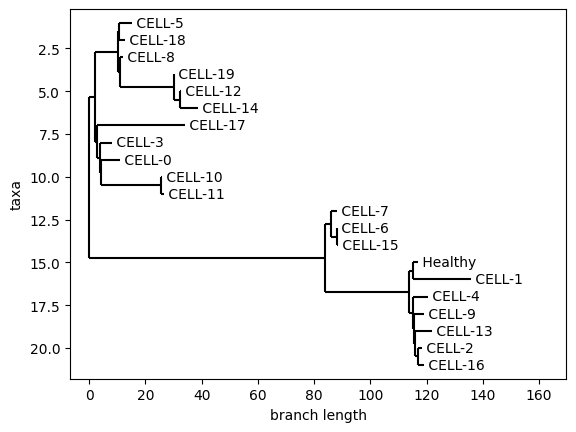

In [58]:
from Bio import Phylo
import io
import matplotlib.pyplot as plt

# Define your tree in Newick format
root = build_best_tree()

# Parse the tree
tree = Phylo.read(io.StringIO(str(root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()

Building tree with likelihood -21785.315843726363
[('Healthy',), ('CELL-0',), ('CELL-1',), ('CELL-2',), ('CELL-3',), ('CELL-4',), ('CELL-5',), ('CELL-6',), ('CELL-7',), ('CELL-8',), ('CELL-9',), ('CELL-10',), ('CELL-11',), ('CELL-12',), ('CELL-13',), ('CELL-14',), ('CELL-15',), ('CELL-16',), ('CELL-17',), ('CELL-18',), ('CELL-19',), ('CELL-6', 'CELL-15'), ('CELL-10', 'CELL-11'), ('CELL-16', 'CELL-2'), ('CELL-14', 'CELL-12'), ('CELL-19', 'CELL-14', 'CELL-12'), ('CELL-1', 'Healthy'), ('CELL-5', 'CELL-18'), ('CELL-16', 'CELL-2', 'CELL-13'), ('CELL-16', 'CELL-2', 'CELL-13', 'CELL-9'), ('CELL-19', 'CELL-14', 'CELL-12', 'CELL-8'), ('CELL-0', 'CELL-10', 'CELL-11'), ('CELL-4', 'CELL-16', 'CELL-2', 'CELL-13', 'CELL-9'), ('CELL-19', 'CELL-14', 'CELL-12', 'CELL-8', 'CELL-5', 'CELL-18'), ('CELL-0', 'CELL-10', 'CELL-11', 'CELL-3'), ('CELL-7', 'CELL-6', 'CELL-15'), ('CELL-1', 'Healthy', 'CELL-4', 'CELL-16', 'CELL-2', 'CELL-13', 'CELL-9'), ('CELL-0', 'CELL-10', 'CELL-11', 'CELL-3', 'CELL-17'), ('CELL

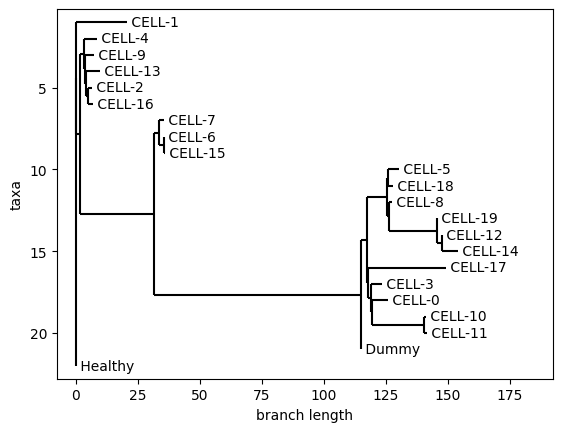

In [59]:
root = build_best_tree()
healthy = root.find("Healthy")
new_root = re_root_tree(healthy.parent, healthy)
new_root = Inner(new_root, healthy, 0, 0)

# Parse the tree
tree = Phylo.read(io.StringIO(str(new_root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()

### Reference for the toy set, generated by Cellphy


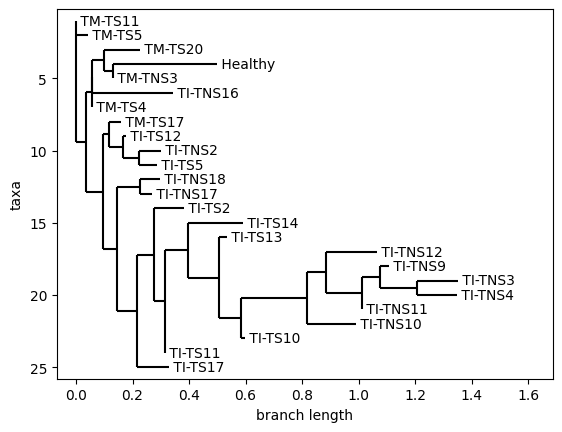

In [60]:
Phylo.draw(
    Phylo.read(
        io.StringIO(
            str(
                "(TM-TS11:0.000697,TM-TS5:0.042828,((((TM-TS20:0.126825,(Healthy:0.369753,TM-TNS3:0.000001):0.029996):0.044345,TI-TNS16:0.288289):0.000001,TM-TS4:0.000001):0.018892,((TM-TS17:0.043174,(TI-TS12:0.010514,(TI-TNS2:0.078992,TI-TS5:0.062256):0.055318):0.051424):0.019990,((TI-TNS18:0.069373,TI-TNS17:0.041607):0.083231,((TI-TS2:0.107810,((TI-TS14:0.193486,(TI-TS13:0.031036,(((TI-TNS12:0.182477,((TI-TNS9:0.032257,(TI-TNS3:0.144277,TI-TNS4:0.141257):0.130157):0.063098,TI-TNS11:0.000001):0.128916):0.067295,TI-TNS10:0.175639):0.231864,TI-TS10:0.012006):0.079301):0.108381):0.083206,TI-TS11:0.000001):0.037688):0.058647,TI-TS17:0.113370):0.072656):0.048018):0.059838):0.036442);"
            )
        ),
        "newick",
    )
)
plt.show()